# Ames Iowa House Price Predictions: Data Cleaning and Exploratory Data Analysis
In this notebook I will clean the data and do analysis of the target and the features included to determin what transformations need to be performed to get it ready for modeling.

## Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from model_helpers import drop_max_vif, ordinalize, box_plot_columns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import RidgeCV

## Data Imports

In [2]:
df = pd.read_csv('./datasets/train.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()
df1 = df.copy()

# Kaggle competition data
k_df = pd.read_csv('./datasets/test.csv') 
k_df.columns = k_df.columns.str.replace(' ', '_').str.lower()
kdf1 = k_df.copy()

pd.set_option(
    'display.max_columns', 
    None
)

pd.set_option(
    'display.max_rows',
    81
)

In [3]:
df1.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


## Missing Values

**Missing values in this dataset will be classified in two general groups:**
1) NA = Meaningful: Represents that a missing value in a given feature column corresponds to a lack of the feature observed. (e.g. a house without a Fence will have a missing value in the 'Fence' column signifying that the house has no fence).
    * Categorical variables in this class will be imputed with the string "None".
    * Numeric variables in this class will be imputed with either an integer or float value of zero.
2) NA = Missing: Represents that any missing values will need to be imputed based on a given measure of the other values in that feature.
    * Categorical variables in this class will primarily be mode imputed.
    * Numeric variables of this class will be either mean or median imputed.
    * When possible, mean, median, and mode imputation will be performed on pandas.GroupBy objects to achieve more representative estimation of features using observations that are likely to be similar.

Class|Subclass|Impute Value|Features
---|---|---|---
1|Categorical|"None"|'MSSubClass', 'MSZoning', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu','GarageFinish', 'GarageQual', 'GarageCond', 'GarageType', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual'
1|Numeric|0|'GarageArea', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1', 'GarageCars', 'BsmtHalfBath', 'BsmtFullBath'
2|Categorical|Mode|'MasVnrType' ('Electrical' test data only)
2|Numeric|Mean/Median|'LotFrontage', 'GarageYrBlt', 'MasVnrArea'

In [4]:
na_sums = df.isna().sum()
na_cols = [na_sums.index[x] for x in range(len(na_sums)) if na_sums[x] != 0]
df1[na_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lot_frontage    1721 non-null   float64
 1   alley           140 non-null    object 
 2   mas_vnr_type    2029 non-null   object 
 3   mas_vnr_area    2029 non-null   float64
 4   bsmt_qual       1996 non-null   object 
 5   bsmt_cond       1996 non-null   object 
 6   bsmt_exposure   1993 non-null   object 
 7   bsmtfin_type_1  1996 non-null   object 
 8   bsmtfin_sf_1    2050 non-null   float64
 9   bsmtfin_type_2  1995 non-null   object 
 10  bsmtfin_sf_2    2050 non-null   float64
 11  bsmt_unf_sf     2050 non-null   float64
 12  total_bsmt_sf   2050 non-null   float64
 13  bsmt_full_bath  2049 non-null   float64
 14  bsmt_half_bath  2049 non-null   float64
 15  fireplace_qu    1051 non-null   object 
 16  garage_type     1938 non-null   object 
 17  garage_yr_blt   1937 non-null   f

In [5]:
kna_sums = kdf1.isna().sum()
kna_cols = [kna_sums.index[x] for x in range(len(kna_sums)) if kna_sums[x] != 0]
kdf1[kna_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lot_frontage    718 non-null    float64
 1   alley           58 non-null     object 
 2   mas_vnr_type    877 non-null    object 
 3   mas_vnr_area    877 non-null    float64
 4   bsmt_qual       853 non-null    object 
 5   bsmt_cond       853 non-null    object 
 6   bsmt_exposure   853 non-null    object 
 7   bsmtfin_type_1  853 non-null    object 
 8   bsmtfin_type_2  853 non-null    object 
 9   electrical      877 non-null    object 
 10  fireplace_qu    456 non-null    object 
 11  garage_type     834 non-null    object 
 12  garage_yr_blt   833 non-null    float64
 13  garage_finish   833 non-null    object 
 14  garage_qual     833 non-null    object 
 15  garage_cond     833 non-null    object 
 16  pool_qc         4 non-null      object 
 17  fence           172 non-null    obj

### Organize Columns According to Imputation Method

In [6]:
fillna_none = [
    'pool_qc', 'misc_feature', 'alley', 'fence', 'fireplace_qu',
    'garage_finish', 'garage_qual', 'garage_cond', 'garage_type',
    'bsmt_exposure', 'bsmtfin_type_2', 'bsmtfin_type_1', 'bsmt_cond', 
    'bsmt_qual', 
]

fillna_zero = [
    'garage_area', 'total_bsmt_sf', 'bsmt_unf_sf', 
    'bsmtfin_sf_2', 'bsmtfin_sf_1', 'garage_cars', 'bsmt_half_bath', 
    'bsmt_full_bath'
]

fillna_impute_num =[
    'lot_frontage', 'garage_yr_blt', 'mas_vnr_area'
]

fillna_impute_cat = [
    'mas_vrn_type',
    'electrical'
]                

### Impute Values
*All missing values requiring calculation to arrive at imputed values will be calculated using only the testing data to avoid data leakage*
#### Null Values as Lack of Feature
Replace missing values with 'None' where it indicates the lack of a feature.

In [7]:
df1.loc[:, fillna_none] = df1.loc[:, fillna_none].fillna('None')
print(df1[fillna_none].isna().sum().sum())

kdf1.loc[:, fillna_none] = kdf1.loc[:, fillna_none].fillna('None')
print(kdf1[fillna_none].isna().sum().sum())

0
0


#### Null Values to Replace with Zero

In [8]:
df1.loc[:, fillna_zero] = df1.loc[:, fillna_zero].fillna(0)
print(df1[fillna_zero].isna().sum().sum())

kdf1.loc[:, fillna_zero] = kdf1.loc[:, fillna_zero].fillna(0)
print(kdf1[fillna_zero].isna().sum())

0
garage_area       0
total_bsmt_sf     0
bsmt_unf_sf       0
bsmtfin_sf_2      0
bsmtfin_sf_1      0
garage_cars       0
bsmt_half_bath    0
bsmt_full_bath    0
dtype: int64


#### Null Values to Be Imputed

1) **Lot Frontage**

Any missing values will be imputed using the mean lot frontage for the same types of buildings in the test data set.

In [9]:
df1.groupby('bldg_type')['lot_frontage'].mean()

bldg_type
1Fam      73.485512
2fmCon    71.340909
Duplex    69.396825
Twnhs     24.507937
TwnhsE    42.698529
Name: lot_frontage, dtype: float64

* Impute mean LotFrontage by building type

In [10]:
df1['lot_frontage'] = df1['lot_frontage'].fillna(df1.groupby('bldg_type')['lot_frontage'].transform('mean'))
print(df1['lot_frontage'].isna().sum())

kdf1['lot_frontage'] = df1['lot_frontage'].fillna(df1.groupby('bldg_type')['lot_frontage'].transform('mean'))
print(kdf1['lot_frontage'].isna().sum())

0
0


2) **GarageYrBlt**

Any missing values will be imputed using the year the house was built.

In [11]:
df1['garage_yr_blt'].isna().sum()

114

In [12]:
df1['garage_yr_blt'] = df1['garage_yr_blt'].fillna(df1['year_built'])
print(df1['garage_yr_blt'].isna().sum())

kdf1['garage_yr_blt'] = kdf1['garage_yr_blt'].fillna(kdf1['year_built'])
print(kdf1['garage_yr_blt'].isna().sum())

0
0


In [13]:
df1.groupby('neighborhood')['mas_vnr_type']

3. **MasVnrType / MasVnrArea**

Any missing values for the masonry type will be imputed using the most common (mode) masonry veneer type for other houses in the same neighborhood. Masonry Area will be imputed with zero if the masonry type is none. Otherwise, the area will be imputed with the median masonry area for other hosues in the same neighborhood.

In [14]:
df1['mas_vnr_type'] = df1['mas_vnr_type'].fillna(df1.groupby('neighborhood')['mas_vnr_type'].transform(lambda x: x.value_counts().index[0]))
print(df1['mas_vnr_type'].isna().sum())

kdf1['mas_vnr_type'] = kdf1['mas_vnr_type'].fillna(df1.groupby('neighborhood')['mas_vnr_type'].transform(lambda x: x.value_counts().index[0]))
print(kdf1['mas_vnr_type'].isna().sum())

0
0


In [15]:
mas_z_mask = df1['mas_vnr_type'] == 'None'
df1.loc[mas_z_mask, 'mas_vnr_type'] = df1.loc[mas_z_mask, 'mas_vnr_type'].fillna(0)

kmas_z_mask = kdf1['mas_vnr_type'] == 'mas_vnr_type'
kdf1.loc[kmas_z_mask, 'mas_vnr_type'] = kdf1.loc[kmas_z_mask, 'mas_vnr_type'].fillna(0)

In [16]:
df1[df1['mas_vnr_type'].isna()]

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice


In [17]:
df1['mas_vnr_area'] = df1['mas_vnr_area'].fillna(df1.groupby('neighborhood')['mas_vnr_area'].transform('median'))
print(df1['mas_vnr_area'].isna().sum())

kdf1['mas_vnr_area'] = kdf1['mas_vnr_area'].fillna(df1.groupby('neighborhood')['mas_vnr_area'].transform('median'))
print(kdf1['mas_vnr_area'].isna().sum())

0
0


4. **Electrical**

In [18]:
kdf1['electrical'] = kdf1['electrical'].fillna(df1.groupby('year_built')['electrical'].transform(lambda x: x.value_counts().index[0]))
print(kdf1['electrical'].isna().sum())

0


In [19]:
df1.isna().sum().sum()

0

In [20]:
kdf1.isna().sum().sum()

0

## Data Types

*Not all features in the col_to_ordinal list will be converted to ordinal values, but all will be tested to see if such a transformation might allow for dimensionality reduction*

In [21]:
col_to_object = [
    'ms_subclass',
]

col_to_binary = [
    'street', 
    'central_air', 
]

col_to_ordinal = [
    'neighborhood',
    'exter_qual',
    'kitchen_qual',
    'bsmt_qual',
    'garage_finish',
    'garage_type',
    'ms_subclass',
    'foundation',
    'heating_qc',
    'exterior_1st',
    'exterior_2nd',
    'mas_vnr_type',
    'exter_cond',
    'bsmtfin_type_1',
    'fireplace_qu',
    'sale_type',
]
col_to_cyclical = [
    'mo_sold',
]

#### Numeric Columns to Strings

In [22]:
df1[col_to_object] = df1[col_to_object].astype(str)
print(df1[col_to_object].dtypes)

kdf1[col_to_object] = kdf1[col_to_object].astype(str)
print(kdf1[col_to_object].dtypes)

ms_subclass    object
dtype: object
ms_subclass    object
dtype: object


#### Categorical Columns to Binary Variables

In [23]:
for dataframe in [df1, kdf1]:
    
    if dataframe['street'].dtype == 'object':
        dataframe['street'] = dataframe['street'].map({'Pave': 1, 'Grvl': 0})
    
    if dataframe['central_air'].dtype =='object':
        dataframe['central_air'] = dataframe['central_air'].map({'Y': 1, 'N': 0})
    

# Exploratory Data Analysis

In [24]:
sns.set_style('darkgrid')

title_font = {
    'family': 'calibri',
    'color': 'black',
    'size': '30',
    'weight': 'bold'
}

label_font = {
    'family': 'calibri',
    'color': 'black',
    'size': '20',
    'weight': 'semibold'
}

ticks_font = {
    'family': 'calibri',
    'color': 'black',
    'size': '15',
    'weight': 'semibold'
}


## Outliers:


findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


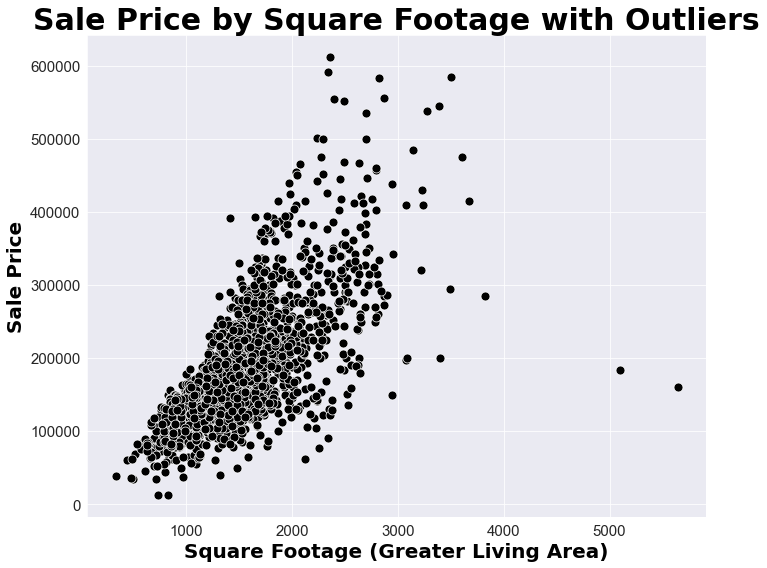

In [25]:
plt.figure(figsize=(10, 8))

sns.scatterplot(x = df1['gr_liv_area'], 
                y = df1['saleprice'],
                color='black',
                s=80,
               )
plt.title('Sale Price by Square Footage with Outliers', title_font)
plt.xlabel('Square Footage (Greater Living Area)', label_font)
plt.ylabel('Sale Price', label_font)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout();

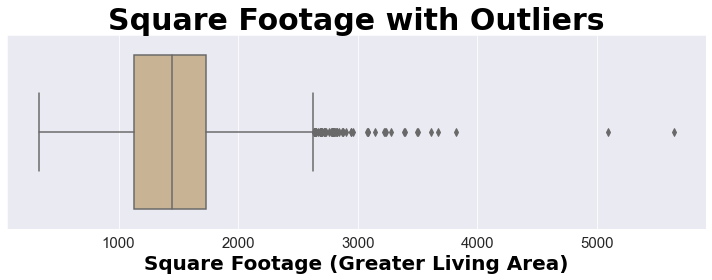

In [26]:
plt.figure(figsize=(10, 4))
sns.boxplot(x = df['gr_liv_area'], color = 'tan')
plt.title('Square Footage with Outliers', title_font)
plt.xlabel('Square Footage (Greater Living Area)', label_font)
plt.xticks(fontsize=15)
plt.tight_layout();

**House size is likely to be one of the most important predictors of house price. The strong correlation is evident in the plot above, but the outliers may have a negative effect on our model. While I will be leaving most ouliters in the training data, I will remove the observations above 5000sq ft.**

In [27]:
outlier_mask = df1['gr_liv_area'] > 5000
#df1 = df1[~ outlier_mask]

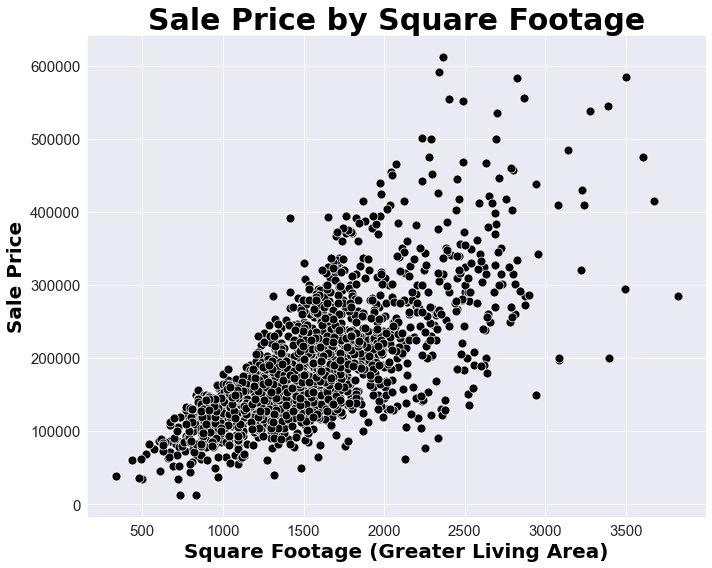

In [28]:
plt.figure(figsize=(10, 8))

sns.scatterplot(x = df1[~ outlier_mask]['gr_liv_area'], 
                y = df1['saleprice'],
                s=80,
                legend='auto',
                color='black'
               )
plt.title('Sale Price by Square Footage', title_font)
plt.xlabel('Square Footage (Greater Living Area)', label_font)
plt.ylabel('Sale Price', label_font)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout();

## Distribution
While the relationship between square footage and sale price is clearer without outliers in the graph above, the skewed distribution of house prices is also starting to come through in this plot. It will be clearer when viewed as a histogram

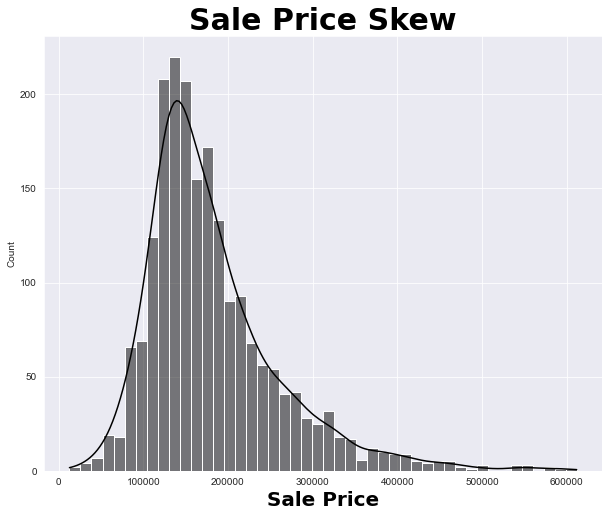

In [55]:
plt.figure(figsize=(10, 8))
sns.histplot(df1['saleprice'],
             kde = True,
             color='black')
plt.title('Sale Price Skew', title_font)
plt.xlabel('Sale Price', label_font)
plt.savefig('./images/sale_price_skew.png');

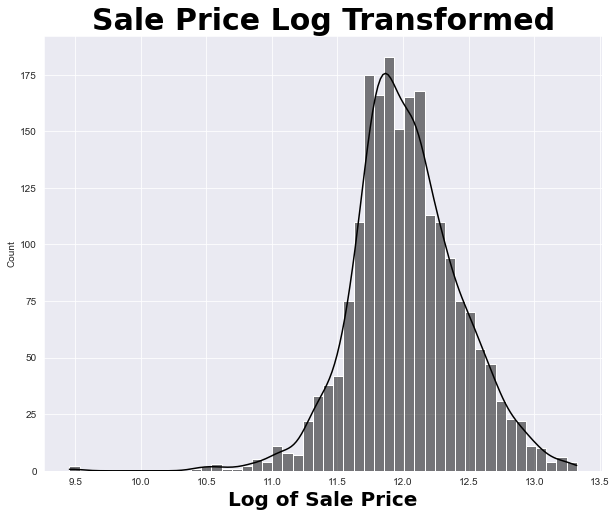

In [56]:
plt.figure(figsize=(10, 8))
sns.histplot(np.log(df1['saleprice']),
             kde = True,
             color='black')
plt.title('Sale Price Log Transformed', title_font)
plt.xlabel('Log of Sale Price', label_font)
plt.savefig('./images/sale_price_transform.png');

**After applying a log transformation, the target is much closer to being normally distributed, which will likely help improve model performance.**

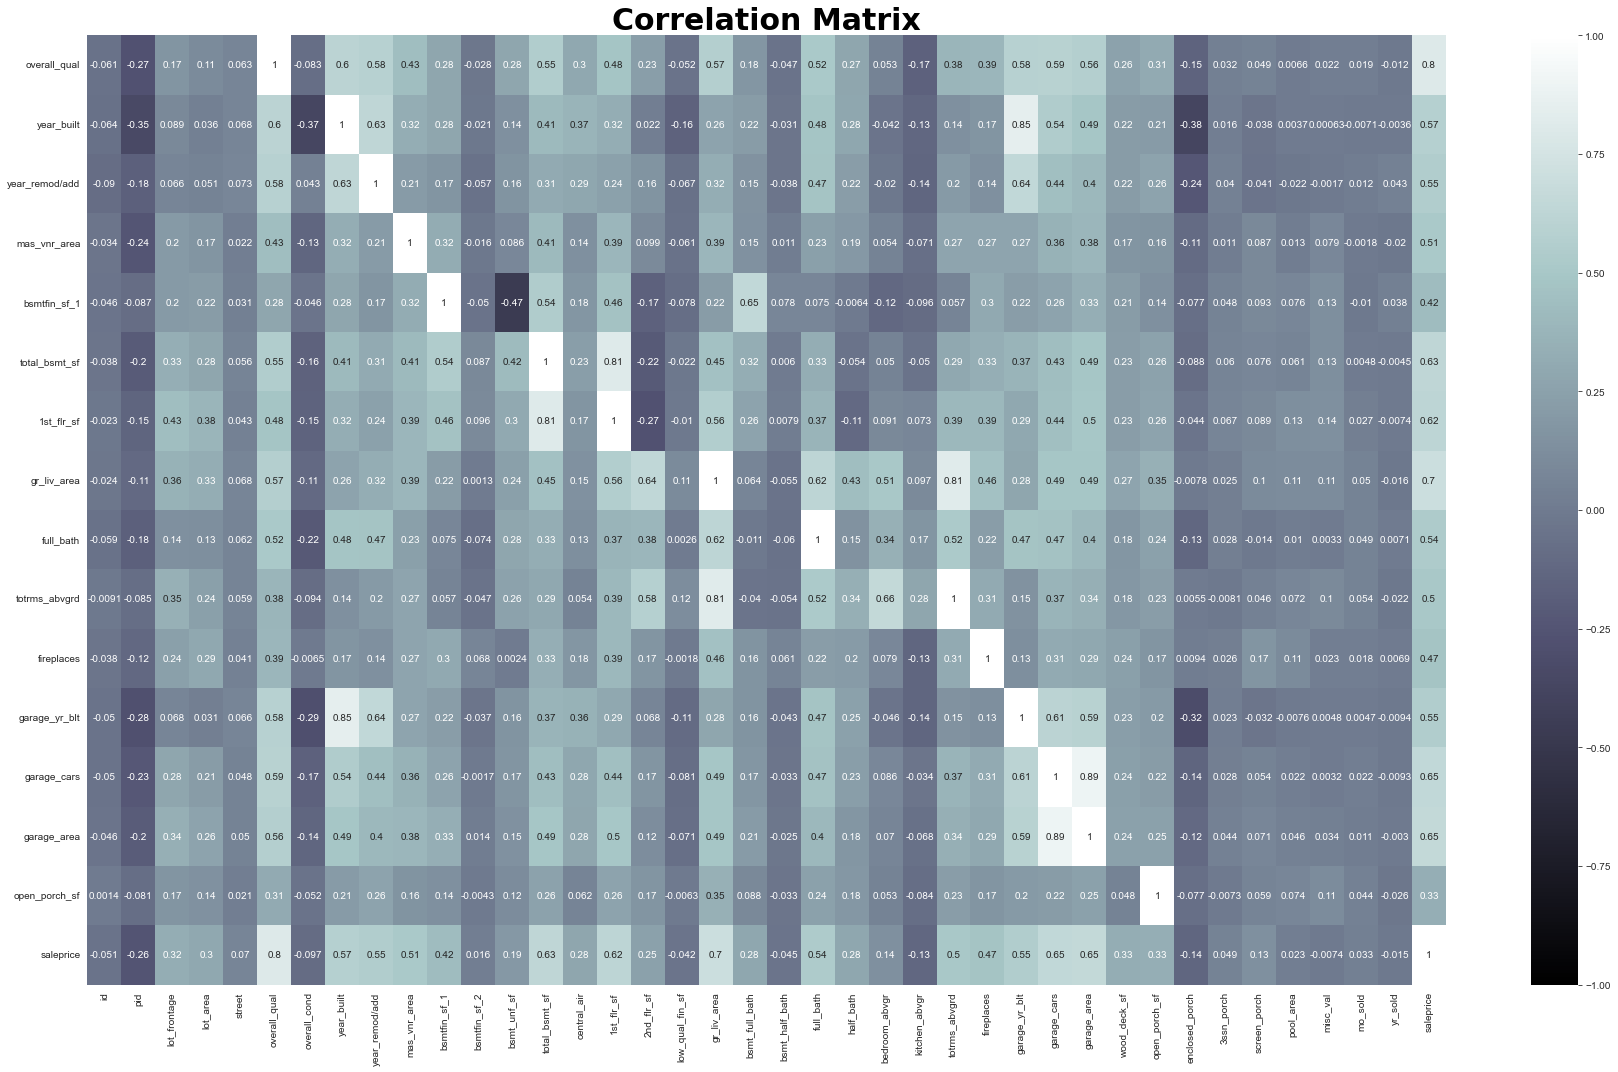

In [31]:
high_corr = (np.abs(df1.corr()['saleprice']) > .33)

plt.figure(figsize=(25, 15))
sns.heatmap(df1.corr()[high_corr],
            annot=True,
            cmap='bone',
            vmax=1,
            vmin=-1,
           )
plt.title('Correlation Matrix', title_font)
plt.tight_layout()

* Garage Year Built and Year Built are highly correlated with each other. One Could probably be dropped.
* Total Rooms Above Ground and Greater Living Area are highly correlated. An avg room size custom feature could allow Total Rooms to be dropped without losing valuable information.
* Garage Area and Garage Cars are also highly correlated. One can be dropped.

**Drop:**
Garage Cars, Total Rooms Above Ground, Garage Year Build

In [32]:
df1.loc[:, 'room_size'] = (df1.loc[:, '1st_flr_sf'] + df1.loc[:, '2nd_flr_sf']) / df1.loc[:, 'totrms_abvgrd'] 
kdf1.loc[:, 'room_size'] = (kdf1.loc[:, '1st_flr_sf'] + kdf1.loc[:, '2nd_flr_sf']) / kdf1.loc[:, 'totrms_abvgrd'] 

df1.loc[:, 'total_baths'] = (df1.loc[:, 'bsmt_full_bath'] + (.5 * df1.loc[:, 'bsmt_half_bath'] + df1.loc[:, 'half_bath']) + df1.loc[:, 'full_bath'])
kdf1.loc[:, 'total_baths'] = (kdf1.loc[:, 'bsmt_full_bath'] + (.5 * kdf1.loc[:, 'bsmt_half_bath'] + kdf1.loc[:, 'half_bath']) + kdf1.loc[:, 'full_bath'])

df1.loc[:, 'total_area'] = (df1.loc[:, 'gr_liv_area'] + df1.loc[:, 'total_bsmt_sf'] + df1.loc[:, 'garage_area'] - (df1.loc[:, 'low_qual_fin_sf']))
kdf1.loc[:, 'total_area'] = (kdf1.loc[:, 'gr_liv_area'] + kdf1.loc[:, 'total_bsmt_sf'] + kdf1.loc[:, 'garage_area'] - (kdf1.loc[:, 'low_qual_fin_sf']))

df1.loc[:, 'total_porch_area'] = (df1.loc[:, 'open_porch_sf'] + df1.loc[:, 'wood_deck_sf'] + df1.loc[:, 'screen_porch'] + df1.loc[:, '3ssn_porch'])
kdf1.loc[:, 'total_porch_area'] = (kdf1.loc[:, 'open_porch_sf'] + kdf1.loc[:, 'wood_deck_sf'] + kdf1.loc[:, 'screen_porch'] + kdf1.loc[:, '3ssn_porch'])

df1.loc[:, 'age'] = (df1.loc[:, 'yr_sold'] - df1.loc[:, 'year_built'])
kdf1.loc[:, 'age'] = (kdf1.loc[:, 'yr_sold'] - kdf1.loc[:, 'year_built'])

In [33]:
df1.drop(columns=['garage_cars',
                  'garage_yr_blt', 
                  'totrms_abvgrd'
                 ], inplace=True
        )

kdf1.drop(columns=['garage_cars',
                  'garage_yr_blt', 
                  'totrms_abvgrd'
                 ], inplace=True
        )

In [34]:
df1.isna().sum().sum()

0

In [35]:
kdf1.isna().sum().sum()

0

#### Save Cleaned Data

In [36]:
df1.to_csv('./datasets/train_cleaned.csv', index=False)
kdf1.to_csv('./datasets/test_cleaned.csv', index=False)

## Categorical Variables

In [37]:
categorical = df1.drop(columns=col_to_ordinal).select_dtypes('object').columns.to_list()

#### Categorical Variables with Strong Linear Relationship to Sale Price
For these features with a strong linear relationship to the target, I decided to encode them as ordinal variables with automatically generated ordinal values that correspond to the median saleprice of the given category within the feature. This served to reduce the complexity of the model without sacrificing valuable information.

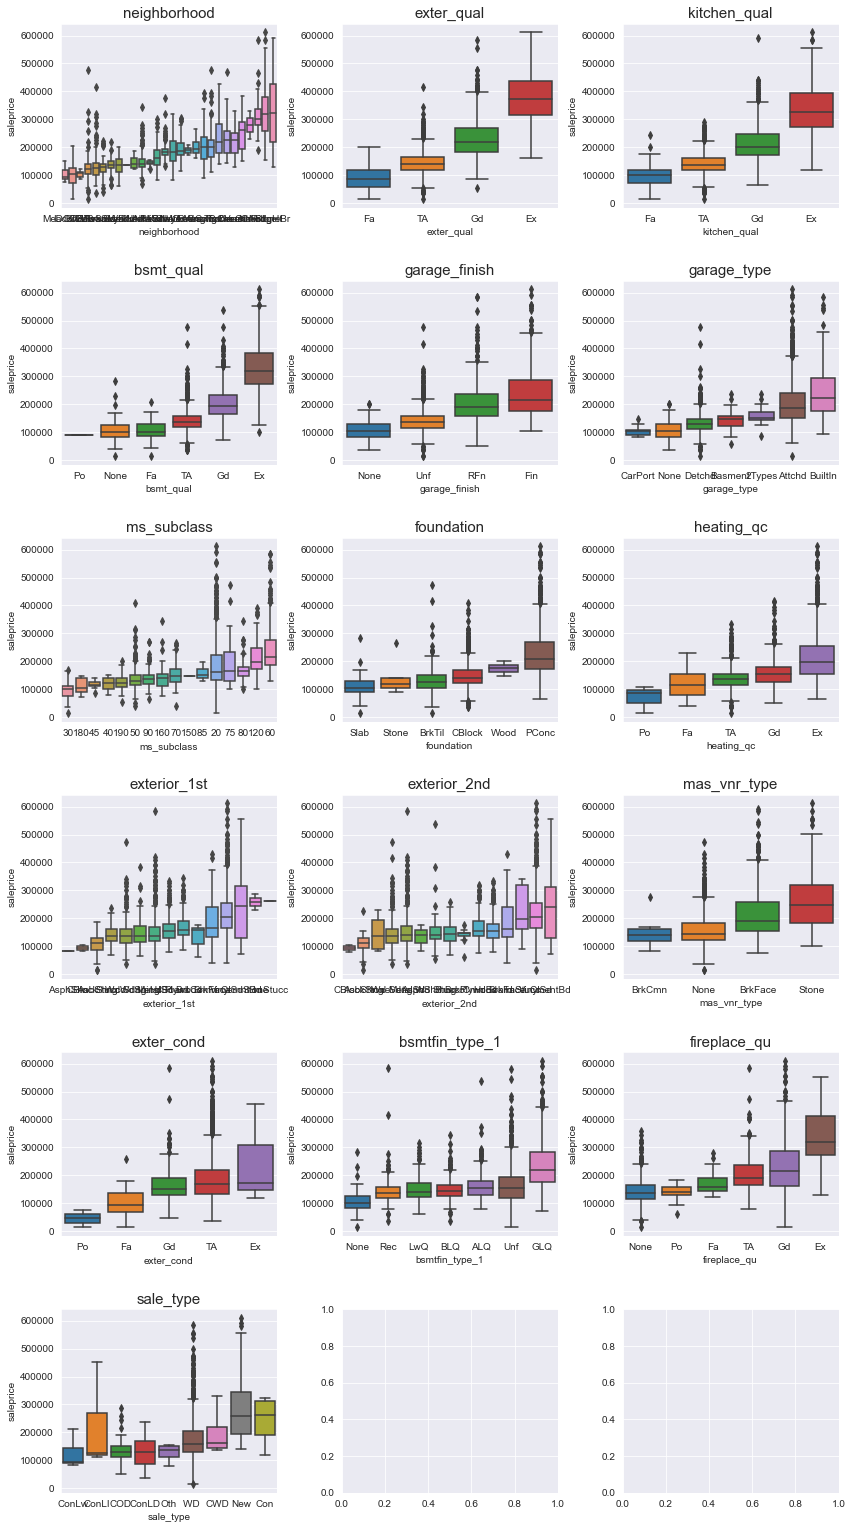

In [38]:
box_plot_columns(df1, col_to_ordinal, 'saleprice')

In [39]:
col_to_ordinal = [
    'neighborhood',
    'exter_qual',
    'kitchen_qual',
    'bsmt_qual',
    'garage_finish',
    'garage_type',
    'ms_subclass',
    'foundation',
    'heating_qc',
    'exterior_1st',
    'exterior_2nd',
    'mas_vnr_type',
    'exter_cond',
    'bsmtfin_type_1',
    'fireplace_qu',
    'sale_type',
]

ords = df1[col_to_ordinal].copy()
k_ords = kdf1[col_to_ordinal].copy()

auto_ordial_cols = col_to_ordinal.copy()
for item in ['kitchen_qual']:
    auto_ordial_cols.remove(item)


for col in auto_ordial_cols:
    ords[col], ord_dict = ordinalize(df1, col, 'saleprice', return_dict=True, suppress_print=True)
    k_ords[col] = ordinalize(kdf1, col, rank_dict=ord_dict, target=None, suppress_print=True)

kq_dict = {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
ords['kitchen_qual'] = ordinalize(df1, 'kitchen_qual', 'saleprice', rank_dict=kq_dict, suppress_print=True)
k_ords['kitchen_qual'] = ordinalize(kdf1, 'kitchen_qual',rank_dict=kq_dict, target=None, suppress_print=True)

for dataframe in [ords, k_ords]:
    dataframe.drop(columns = col_to_ordinal)
    
df_ord = df1.drop(columns=col_to_ordinal)
df_ord = pd.concat([df_ord, ords], axis=1)

kdf_ord = kdf1.drop(columns=col_to_ordinal)
kdf_ord = pd.concat([kdf_ord, k_ords], axis=1)

In [40]:
df_ord.isna().sum().sum()

0

In [41]:
kdf1.isna().sum().sum()

0

#### Categorical Features with Categories Median-Sorted by Price

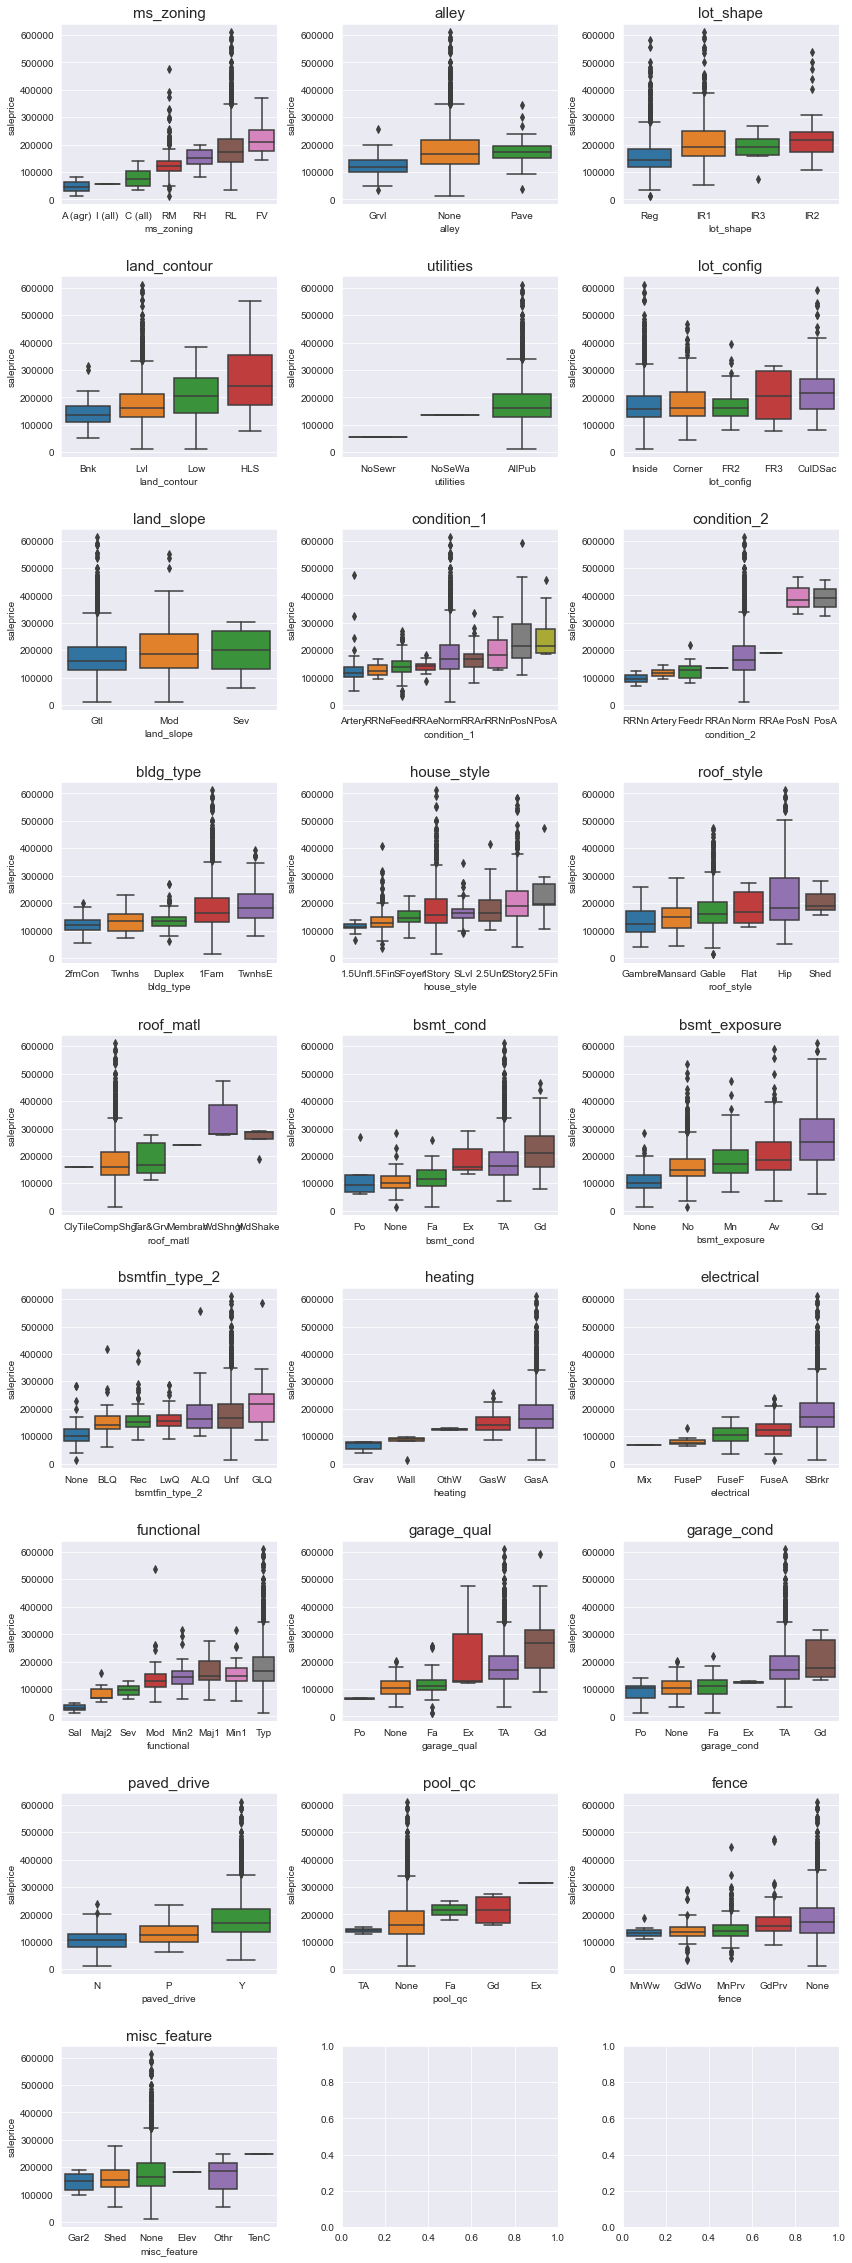

In [42]:
box_plot_columns(df1, categorical, 'saleprice')

#### Categorical Variables for Prices over $250,000:
Even with the target variable normalized with a log transformation, the model is likely to underperform at higher house prices. These plots help vizualize trends among higher priced houses to help select features to ensure are included in the model.

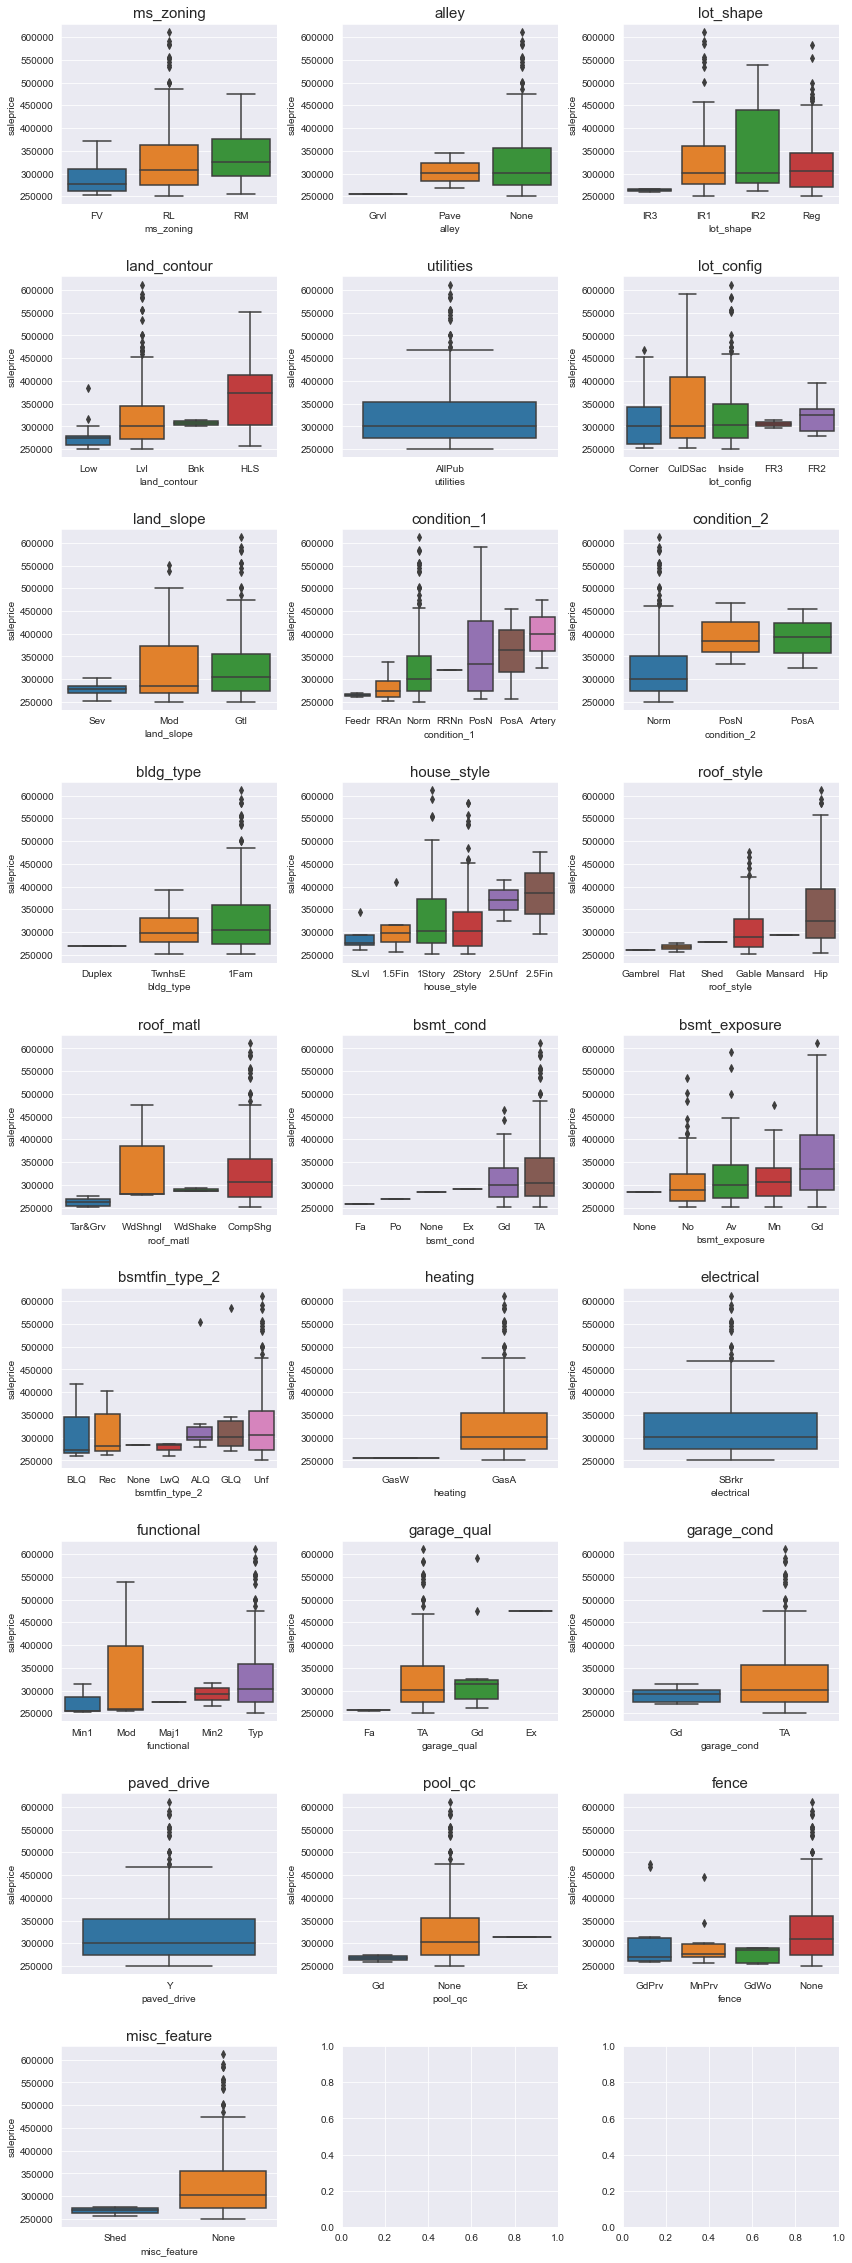

In [43]:
box_plot_columns(df1[df1['saleprice'] > 250000], categorical, 'saleprice')

In [44]:
cat_df = df_ord.select_dtypes('object')
cat_kdf = kdf_ord.select_dtypes('object')

ohe = OneHotEncoder(drop='first', handle_unknown = 'ignore', sparse=False)
feat_array = ohe.fit_transform(cat_df)
kfeat_array = ohe.transform(cat_kdf)
ohe_labels = ohe.get_feature_names_out(input_features=cat_df.columns)

ohe_df = pd.DataFrame(feat_array, columns=ohe_labels)
ohe_kdf = pd.DataFrame(kfeat_array, columns=ohe_labels)

/Users/jacksonnelson/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [12, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [45]:
ohe_df.isna().sum().sum()
ohe_df.shape

(2051, 113)

In [46]:
ohe_kdf.isna().sum().sum()

0

## Feature Transformations
Some of the features of our model may benefit from a similar transformation to the target in order to be more normally distributed.

In [47]:
# Learned about skew() method and used moderate thresholds found here: https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de#:~:text=skewness()%20function%20in%20pandas,present%20in%20the%20DataFrame%20object.
def skew_comparison_df(dataframe, target, drop=None):
    if drop == None:
        drop = target
    X = dataframe.drop(columns=drop)
    numeric = X.select_dtypes(np.number).columns
    skews = np.abs(X[numeric].skew())
    log_X = np.log(X[numeric] + 1)
    y = dataframe[target]
    log_y = np.log(dataframe[target])
    
    sdf = pd.DataFrame(skews, columns=['skew'])
    
    sdf['y_corr'] =X[numeric].corrwith(y).values
    sdf['log_y_corr'] =X[numeric].corrwith(log_y).values
    sdf['tx_skew'] = log_X.skew().values
    sdf['tx_feat_y_corr'] = log_X.corrwith(y).values
    sdf['tx_feat_log_y_corr'] = log_X.corrwith(log_y).values
    
    
    return sdf

In [48]:
df_log = df1.select_dtypes(np.number).copy()
kdf_log = kdf1.select_dtypes(np.number).copy()

df_log.drop(columns=['id', 'pid'], inplace=True)
kdf_log.drop(columns=['id', 'pid'], inplace=True)

# Some code in this function was adapted from an approach found here: https://medium.com/@atanudan/kurtosis-skew-function-in-pandas-aa63d72e20de#:~:text=skewness()%20function%20in%20pandas,present%20in%20the%20DataFrame%20object.
df_skew_values = skew_comparison_df(df_log, 'saleprice', drop=['saleprice'])
df_skew_values

/Users/jacksonnelson/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,skew,y_corr,log_y_corr,tx_skew,tx_feat_y_corr,tx_feat_log_y_corr
lot_frontage,1.801578,0.322885,0.315170,-0.998635,0.311822,0.311280
lot_area,9.204950,0.296566,0.279942,-0.567041,0.366687,0.360869
street,17.041953,0.069841,0.103906,-17.041953,0.069841,0.103906
overall_qual,0.148461,0.800207,0.822774,-0.754282,0.753713,0.812858
overall_cond,0.638166,-0.097019,-0.037098,-0.594093,-0.059161,0.015170
year_built,0.607913,0.571849,0.624449,-0.634261,0.569609,0.622558
year_remod/add,0.451205,0.550370,0.599459,-0.458173,0.550053,0.599409
mas_vnr_area,2.606925,0.508962,0.446953,0.520627,0.466487,0.455468
bsmtfin_sf_1,1.603376,0.423856,0.409357,-0.604660,0.233875,0.264808
bsmtfin_sf_2,4.241139,0.016432,0.026777,2.448928,-0.036396,-0.016989


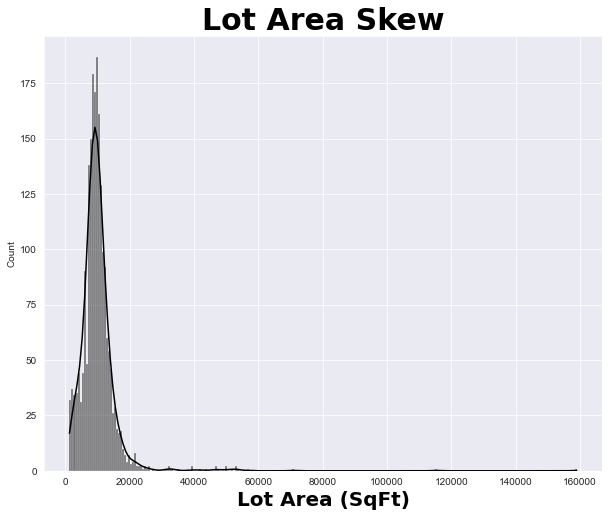

In [60]:
plt.figure(figsize=(10, 8))
sns.histplot(df1['lot_area'],
             kde = True,
             color='black'),
plt.title('Lot Area Skew', title_font)
plt.xlabel('Lot Area (SqFt)', label_font)
plt.savefig('./images/lot_are_skew.png');

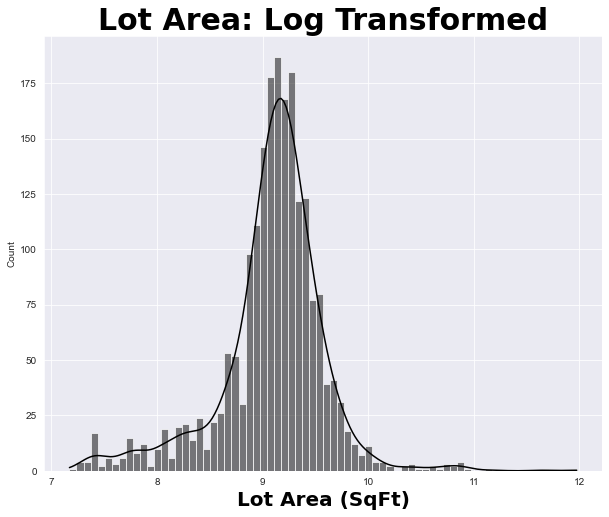

In [58]:
plt.figure(figsize=(10, 8))
sns.histplot(np.log(df1['lot_area']),
             kde = True,
             color='black'),
plt.title('Lot Area: Log Transformed', title_font)
plt.xlabel('Lot Area (SqFt)', label_font)
plt.savefig('./images/lot_are_transform.png');

**The transformation in the case of lot area is drastic, with the log transformed resembling something that approximates a normal curve. For each of the numeric features, I will run a rest to see if the skew of the distribution is improved by a log transformation, and if it is, I will apply the transformation to that feature. If not, it will remain in its given units.**

In [51]:
mask1 = np.abs(df_skew_values['skew']) > np.abs(df_skew_values['tx_skew'])
transform_features = df_skew_values[mask1].index

df_log[transform_features] = df_log[transform_features].apply(lambda x: np.log(x + 1))
kdf_log[transform_features] = kdf_log[transform_features].apply(lambda x: np.log(x + 1))

df_log.drop(columns='saleprice', inplace=True)

In [52]:
df_log.isna().sum().sum()
df_log.shape

(2051, 39)

In [53]:
kdf_log.isna().sum().sum()
kdf_log.shape

(878, 39)

#### Save Data

In [54]:
X = pd.concat([df_log, ohe_df], axis=1)
X = X[~ outlier_mask]
X_k = pd.concat([kdf_log, ohe_kdf], axis=1)

X.to_csv('./datasets/training_data_encoded.csv', index=False)
X_k.to_csv('./datasets/kaggle_data_encoded.csv', index=False)


df1 = df1[~ outlier_mask]
df1.to_csv('./datasets/train_cleaned_outliers_removed.csv', index=False)